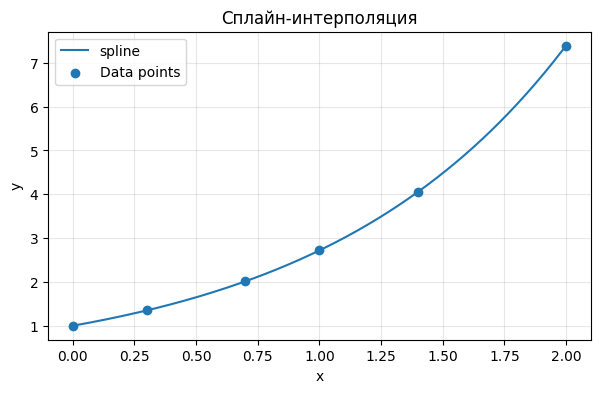

In [11]:
"""
Формат входа:
input_text = '''
x: 0 1 2 3 4 5
y: 0 1 0 1 0 1
xmin: 0
xmax: 5
n_plot: 500
conditions: natural        #natural|clamped
dy0: 0             # (необязательно, только для conditions=clamped) S'(x0)
dyn: 0             # (необязательно, только для conditions=clamped) S'(xn)
'''
"""

from dataclasses import dataclass
from typing import Literal, Optional, Tuple, Dict, Any
import numpy as np
import matplotlib.pyplot as plt
import re


# Парсер ввода

def _parse_numbers(line: str) -> np.ndarray:
    return np.array([float(tok) for tok in line.strip().split()[1:]], dtype=float)

def parse_input(input_text: str) -> Dict[str, Any]:
    """
    Парсит текстовый ввод. Обязательные поля: x:, y:, xmin:, xmax:
    Необязательные: n_plot:, conditions:, dy0:, dyn:
    """
    clean = "\n".join(part.split("#", 1)[0] for part in input_text.splitlines())
    kv = {}
    for raw in clean.splitlines():
        line = raw.strip()
        if not line:
            continue

        if line.startswith("x:"):
            kv["x"] = _parse_numbers(line)
        elif line.startswith("y:"):
            kv["y"] = _parse_numbers(line)
        else:
            m = re.match(r"^([A-Za-z0-9_]+)\s*:\s*(.+)$", line)
            if m:
                key, val = m.group(1).strip().lower(), m.group(2).strip()
                kv[key] = val

    # Преобразования типов и значения по умолчанию
    required = ["x", "y", "xmin", "xmax"]
    missing = [k for k in required if k not in kv]
    if missing:
        raise ValueError(f"Отсутствуют обязательные поля: {', '.join(missing)}")

    kv["xmin"] = float(kv["xmin"])
    kv["xmax"] = float(kv["xmax"])
    if kv["xmin"] >= kv["xmax"]:
        raise ValueError("Требуется xmin < xmax")

    kv["n_plot"] = int(kv.get("n_plot", 400))
    kv["conditions"] = str(kv.get("conditions", "natural")).strip().lower()
    if kv["conditions"] not in ("natural", "clamped"):
        raise ValueError("conditions должен быть 'natural' или 'clamped'")
    if kv["conditions"] == "clamped":
        # производные на концах
        if "dy0" not in kv or "dyn" not in kv:
            raise ValueError("Для conditions='clamped' необходимо задать dy0 и dyn")
        kv["dy0"] = float(kv["dy0"])
        kv["dyn"] = float(kv["dyn"])

    x = kv["x"]
    y = kv["y"]
    if x.shape != y.shape:
        raise ValueError("Массивы x и y должны иметь одинаковую длину")
    if x.size < 2:
        raise ValueError("Нужно как минимум два узла")

    # сортируем по x и проверяем уникальность
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    if np.any(np.diff(x_sorted) == 0):
        raise ValueError("x должен содержать только уникальные значения")

    kv["x"] = x_sorted
    kv["y"] = y_sorted
    return kv


# Кубический сплайн

@dataclass
class CubicSpline1D:
    x: np.ndarray          # узлы, размер n
    y: np.ndarray          # значения, размер n
    M: np.ndarray          # вторые производные в узлах, размер n
    h: np.ndarray          # шаги h_i = x_{i+1}-x_i, размер n-1

    def evaluate(self, xq: np.ndarray) -> np.ndarray:
        """
        Вычисляет значения сплайна в точках xq.
        Экстраполяция за пределами [x0, xn] - линейная по ближайшему участку.
        """
        x, y, M, h = self.x, self.y, self.M, self.h
        n = x.size
        xq = np.asarray(xq, dtype=float)
        yq = np.empty_like(xq, dtype=float)

        # Индексы интервалов для каждой точки запроса
        # Для xq < x0 -> используем интервал [x0, x1]
        # Для xq > xn -> используем интервал [x_{n-2}, x_{n-1}]
        idx = np.searchsorted(x, xq, side="right") - 1
        idx = np.clip(idx, 0, n - 2)

        # Кубический сплайн на интервале [x_i, x_{i+1}]
        xi = x[idx]
        xi1 = x[idx + 1]
        hi = h[idx]

        # Вспомогательные
        t = (xq - xi) / hi  # нормализованная координата
        A = (1 - t)
        B = t

        # Коэффициенты формы через M
        # S(x) = Mi*(xi1-x)^3/(6*hi) + Mi1*(x-xi)^3/(6*hi)
        #           + (yi - Mi*hi^2/6)*(xi1-x)/hi + (yi1 - Mi1*hi^2/6)*(x-xi)/hi
        Mi = M[idx]
        Mi1 = M[idx + 1]
        yi = y[idx]
        yi1 = y[idx + 1]

        term1 = Mi * ( (xi1 - xq) ** 3 ) / (6.0 * hi)
        term2 = Mi1 * ( (xq - xi) ** 3 ) / (6.0 * hi)
        term3 = (yi - Mi * hi * hi / 6.0) * (A)
        term4 = (yi1 - Mi1 * hi * hi / 6.0) * (B)
        yq[:] = term1 + term2 + term3 + term4

        return yq


def _build_tridiagonal(n: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Возвращает заготовку под трёхдиагональную систему"""
    a = np.zeros(n - 1, dtype=float)  # поддиагональ
    b = np.zeros(n, dtype=float)      # диагональ
    c = np.zeros(n - 1, dtype=float)  # наддиагональ
    return a, b, c


def _solve_tridiagonal(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    """
    Решение трёхдиагональной СЛАУ методом прогонки
    a: поддиагональ (n-1), b: диагональ (n), c: наддиагональ (n-1), d: правая часть (n)
    """
    n = b.size
    ac, conditions, cc, dc = map(np.array, (a.copy(), b.copy(), c.copy(), d.copy()))

    # Прямой ход
    for i in range(1, n):
        w = ac[i - 1] / conditions[i - 1]
        conditions[i] = conditions[i] - w * cc[i - 1]
        dc[i] = dc[i] - w * dc[i - 1]

    # Обратный ход
    x = np.zeros(n, dtype=float)
    x[-1] = dc[-1] / conditions[-1]
    for i in range(n - 2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i + 1]) / conditions[i]
    return x


def cubic_spline(
    x: np.ndarray,
    y: np.ndarray,
    conditions: Literal["natural", "clamped"] = "natural",
    dy0: Optional[float] = None,
    dyn: Optional[float] = None,
) -> CubicSpline1D:
    """
    Строит кубический сплайн по узлам (x, y)
    conditions='natural' - естественные граничные условия (S''(x0)=S''(xn)=0)
    conditions='clamped' - закреплённые края: задаются S'(x0)=dy0 и S'(xn)=dyn
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = x.size
    if n < 2:
        raise ValueError("Нужно как минимум два узла")

    h = np.diff(x)
    if np.any(h <= 0):
        raise ValueError("x должен быть строго возрастающим")

    # Правая часть
    rhs = np.zeros(n, dtype=float)
    a, b, c = _build_tridiagonal(n)

    if conditions == "natural":
        # Граничные условия: M0 = 0, Mn-1 = 0
        b[0] = 1.0
        b[-1] = 1.0
        rhs[0] = 0.0
        rhs[-1] = 0.0

        for i in range(1, n - 1):
            a[i - 1] = h[i - 1]
            b[i]     = 2.0 * (h[i - 1] + h[i])
            c[i]     = h[i]
            rhs[i]   = 6.0 * ( (y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1] )

    elif conditions == "clamped":
        if dy0 is None or dyn is None:
            raise ValueError("Для conditions='clamped' необходимо указать dy0 и dyn")

        # Первая строка (условие на левую производную)
        b[0] = 2.0 * h[0]
        c[0] = h[0]
        rhs[0] = 6.0 * ( (y[1] - y[0]) / h[0] - dy0 )

        # Внутренние строки
        for i in range(1, n - 1):
            a[i - 1] = h[i - 1]
            b[i]     = 2.0 * (h[i - 1] + h[i])
            c[i]     = h[i]
            rhs[i]   = 6.0 * ( (y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1] )

        # Последняя строка (условие на правую производную)
        a[-1] = h[-1]
        b[-1] = 2.0 * h[-1]
        rhs[-1] = 6.0 * ( dyn - (y[-1] - y[-2]) / h[-1] )

    else:
        raise ValueError("conditions должен быть 'natural' или 'clamped'")

    M = _solve_tridiagonal(a, b, c, rhs)
    return CubicSpline1D(x=x, y=y, M=M, h=h)


# Визуализация
def plot_spline(spline: CubicSpline1D, xmin: float, xmax: float, n_plot: int = 400) -> None:
    xx = np.linspace(xmin, xmax, int(n_plot))
    yy = spline.evaluate(xx)

    plt.figure(figsize=(7, 4))
    plt.plot(xx, yy, label="spline")
    plt.scatter(spline.x, spline.y, zorder=3, label="Data points")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Сплайн-интерполяция")
    plt.grid(True, alpha=0.3)
    plt.legend()


def main(input_text: str) -> CubicSpline1D:
    """
    1) Парсит вход
    2) Строит сплайн
    3) Строит график
    4) Возвращает объект сплайна
    """
    cfg = parse_input(input_text)
    x = cfg["x"]
    y = cfg["y"]
    conditions = cfg["conditions"]
    xmin = cfg["xmin"]
    xmax = cfg["xmax"]
    n_plot = cfg["n_plot"]
    dy0 = cfg.get("dy0", None)
    dyn = cfg.get("dyn", None)
    spline = cubic_spline(x, y, conditions=conditions, dy0=dy0, dyn=dyn)
    plot_spline(spline, xmin=xmin, xmax=xmax, n_plot=n_plot)
    return spline


# 1) Синус на [0, 2π], natural
input_text_sin = '''
x: 0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0 5.5 6.28
y: 0.0 0.47 0.8414 0.9974 0.9092 0.5984 0.1411 -0.3507 -0.7568 -0.9775 -0.9589 -0.70556 -0.0
xmin: 0
xmax: 6.28
n_plot: 600
conditions: natural
'''

# 2) y = x^2 на [−2, 2], natural
input_text_quad = '''
x: -2 -1 0 1 2
y: 4 1 0 1 4
xmin: -2
xmax: 2
n_plot: 400
conditions: natural
'''

# 3.1) Экспонента y = e^x на [0, 2], clamped
# S'(x) = e^x -> S'(0)=1, S'(2)=e^2
input_text_exp_clamped = '''
x: 0 0.3 0.7 1.0 1.4 2.0
y: 1.0 1.3498 2.0137 2.7182 4.0551 7.3890
xmin: 0
xmax: 2
n_plot: 500
conditions: clamped
dy0: 1.00
dyn: 7.3890
'''
# 3.2) Экспонента y = e^x на [0, 2], natural
input_text_exp_natural = '''
x: 0 0.3 0.7 1.0 1.4 2.0
y: 1.0 1.3498 2.0137 2.7182 4.0551 7.3890
xmin: 0
xmax: 2
n_plot: 500
conditions: clamped
dy0: 0
dyn: 0
'''

# 4) Неровномерная сетка y = sqrt(x+1) на [−1, 5], natural conditions
input_text_nonuniform = '''
x: -1 -0.2 0.0 0.1 0.4 1.0 2.0 3.5 5.0
y: 0.0 0.8944 1.0 1.0488 1.1832 1.414 1.7322 2.1213 2.4494
xmin: -1
xmax: 5
n_plot: 450
conditions: natural
'''


# 5) чередующиеся значения
input_text_zigzag = '''
x: 0 1 2 3 4 5 6 7 8
y: 0 1 0 1 0 1 0 1 0
xmin: 0
xmax: 8
n_plot: 500
conditions: natural
'''


# 6) демонстрация поведения у края, clamped 
# Зададим производную 0 на левом краю и 3 на правом
input_text_edge = '''
x: 0 1 2 3 4 5
y: 1 1 1.1 1.2 2.0 4.5
xmin: 0
xmax: 5
n_plot: 500
conditions: clamped
dy0: 0
dyn: 3
'''

# 7) y = cos(x) на [0, 2π], но с очень редкими узлами
input_text_cos_rare = '''
x: 0 1.57 3.14 4.71 6.283185307179586
y: 1.0 0.000796326710733  -1.0  -0.000796326710733  1.0
xmin: 0
xmax: 6.283185307179586
n_plot: 500
conditions: natural
'''
# 8) y≈e−0.03x⋅sin(1.5x)+0.1⋅sin(5x)
input_text_big_natural = '''
x: 0 0.3 0.7 1.2 1.5 2.1 2.4 3.0 3.8 4.1 4.7 5.5 5.8 6.4 7.0 7.3 8.2 8.9 9.1 10.0 10.8 11.2 11.9 12.5 13.0 13.7 14.5 15.1 15.8 16.0 16.6 17.3 18.0 18.4 19.1 19.8 20.0
y: 0.00 0.51 1.18 0.84 0.35 -0.48 -0.86 -0.14 0.89 0.55 -0.40 -0.95 -0.58 0.46 0.97 0.73 0.13 -0.58 -0.83 -0.11 0.85 0.66 -0.32 -0.93 -0.64 0.38 0.98 0.79 0.22 -0.49 -0.90 -0.44 0.61 0.97 0.67 -0.28 -0.75
xmin: 0
xmax: 20
conditions: natural
'''

examples = {
    "sin_natural": input_text_sin,
    "quad_natural": input_text_quad,
    "exp_clamped": input_text_exp_clamped,
    "exp_natural": input_text_exp_natural,
    "nonuniform_natural": input_text_nonuniform,
    "zigzag_natural": input_text_zigzag,
    "edge_clamped": input_text_edge,
    "cos_rare_natural": input_text_cos_rare,
    "exp_sin_natural": input_text_big_natural,
}
spline = main(examples["exp_clamped"])